In [1]:
import dimod
import random
import numpy as np
import matplotlib.pyplot as plt
import math


In [2]:
#Global Parameters
mu=1.0 ; J=1.0 ;Kb=1

In [3]:
#function to specify field B and generate corresponding Binary bqm
def Specification(B):
    b=-1.0*mu*B  #bias
    c=-1.0*J  #coupler
    
   
    linear={0:b, 1: b, 2: b , 3: b , 4:b , 5:b,6:b ,7:b,8:1}
    quadratic={(0,1):c, (0,3):c, (0,2):c ,(0,6):c, (1,2):c, (1,4):c, (1,7):c\
          ,(2,5):c, (2,8):c, (3,4):c, (3,6):c, (3,5):c, (4,5):c, (4,7):c\
          ,(5,8):c, (6,7):c, (6,8):c, (7,8):c}
    
    model = dimod.BinaryQuadraticModel.from_ising(linear,quadratic, offset =0)
    Q=model.to_qubo()
    linear={0:0 ,1:0 ,2:0 ,3:0,4:0,5:0,6:0,7:0,8:0}
    bqm = dimod.BinaryQuadraticModel(linear,Q[0],Q[1],dimod.BINARY)

    return bqm

In [4]:
def coldstart():           #coldstart All spins +1
    U={0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1}
    return U


In [5]:
bqm=Specification(2)
bqm.energy(coldstart())

-33.0

In [6]:
def hotstart():
    U={}
    i=0
    for i in range(9):
        dict1={i:random.choice([0,1])}
        U.update(dict1)
    return U

In [7]:
hotstart()

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0}

In [8]:
U=coldstart()

In [9]:
def spinflipper(U,B):
    bqm=Specification(B)  #Chooses correct BQM for input B
    a=random.randint(1,8)
    initial=U
    H1=bqm.energy(initial)
    t=U[a]
    U[a]=1-t
    final=U
    H2=bqm.energy(final)
    dH=H2-H1
    
    return U,dH,a

In [10]:
spinflipper(U,0)

({0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}, 8.0, 3)

In [11]:
spinflipper(U,0)

({0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1}, 4.0, 4)

In [12]:
def Hamiltonian(U,B):
    bqm=Specification(B)
    H=bqm.energy(U)
    return H

In [13]:
Hamiltonian(U,3)

-17.0

In [14]:
def magnetization(U):
    
    total=0
    for k,v in U.items():
        total= total+v
    
    return total/len(U)    

In [15]:
spinflipper(U,3)
magnetization(U)

0.6666666666666666

In [16]:
def Thermalization(U,T,nrun,printkey,B) :
        M = [0.0 for irun in range(nrun)]
        irun = 0       
        HH = [0.0 for irun in range(nrun)]
       
        while irun < nrun:
                    V = U
                    w = magnetization(U)
                    h = Hamiltonian(U,B)  #B,U,printkey
                    
                    U,dH,p = spinflipper(U,B) #U,B,printkey
                   
                   
                    if dH < 0:
                        
                        if printkey ==1: print(irun, "E decreased! You are accepted !",dH)
                            
                        M[irun] = magnetization(U)
                        HH[irun] = Hamiltonian(U,B)
                       
                    else:
                        
                        if printkey ==1:print(irun, "E increased!",dH)
                            
                        frac = math.exp(-dH/(Kb*T))
                        b = random.uniform(0.0,1.0)
                            
                        if printkey ==1:print("frac =",frac,"b=",b,"dH = ",dH)
                                
                        if  b < frac:
                                    
                            if printkey ==1:print(irun, " You Lucky!")
                                
                            M[irun] = magnetization(U)
                            HH[irun] = Hamiltonian(U,B)
                             
                        else:
                            if printkey ==1: print(irun, "Loser!")
                            if printkey ==1: print("spin restablished at",p)
                            x=U[p]
                            U[p] = 1-x
                            M[irun] = w 
                            HH[irun] = h
                           
                            
                    for i in range(8):
                        if U[i]!= V[i]:
                            if printkey ==1: print("Warning!spin is changed!", i) 
                            
                    
                    
                    
                    if printkey ==2 : print(irun, M[irun])   
                    irun = irun +1
        return M,U,HH

In [17]:

Thermalization(U,2.4,7,0,5)

([0.7777777777777778,
  0.7777777777777778,
  0.8888888888888888,
  0.8888888888888888,
  0.8888888888888888,
  0.8888888888888888,
  0.8888888888888888],
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1},
 [-25.0, -25.0, -39.0, -39.0, -39.0, -39.0, -39.0])

In [18]:
def fields(x):
    L = 9
    nrun = 2000
    Tn = 100
    avm = []
    stdh = []
    KT = []
    B=x
    for t in range(1,Tn+1):
            T = 0.1*t
            KT.append(T)
            U = coldstart()
            M,U,HH = Thermalization(U,T,nrun,0,x)
            nM = M[1500:nrun-1]
            nH = HH[1500:nrun-1]
            stdh.append(np.std(nH))
            avm.append(np.mean(nM))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    axes[0].scatter(KT, avm,s=17)
    axes[0].title.set_text(  ('At B={}'.format(B)))
    axes[0].set_xlabel("Temperature",fontsize='20')
    axes[0].set_ylabel("Average magnetization",fontsize='20')

    axes[1].scatter(KT, stdh,s=17)
    axes[1].set_xlabel("Temperature",fontsize='20')
    axes[1].set_ylabel("Specific Heat Capacity",fontsize='20')

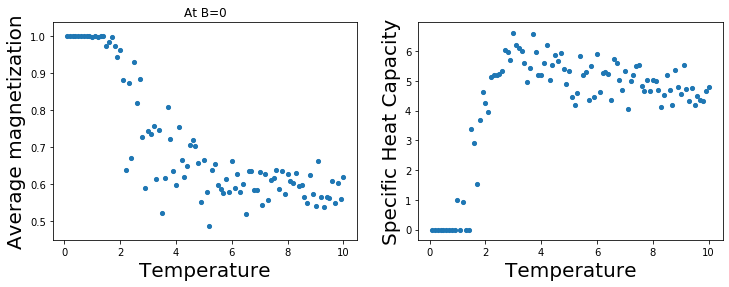

In [19]:
fields(0)

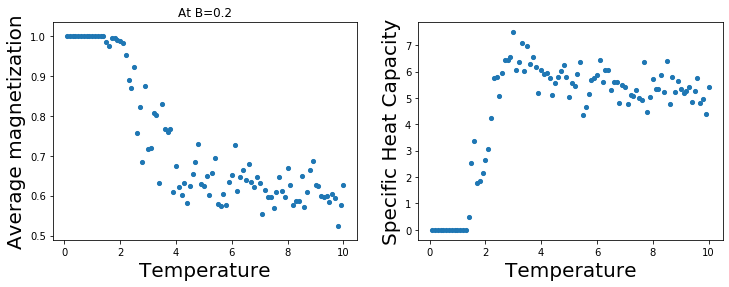

In [20]:
fields(0.2)

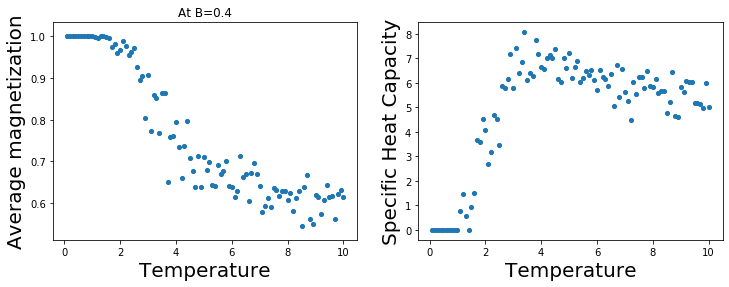

In [21]:
fields(0.4)

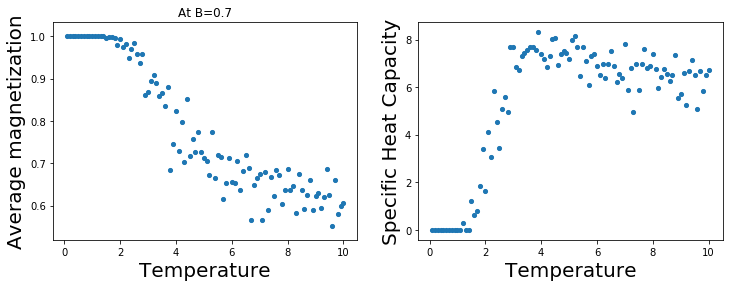

In [22]:
fields(0.7)

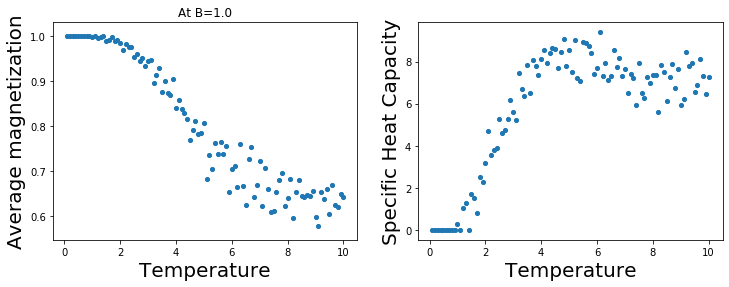

In [23]:
fields(1.0)

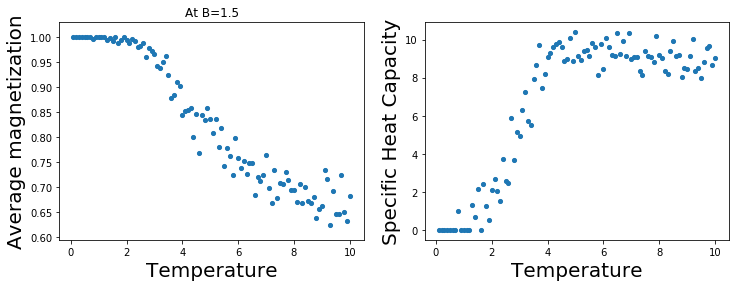

In [24]:
fields(1.5)

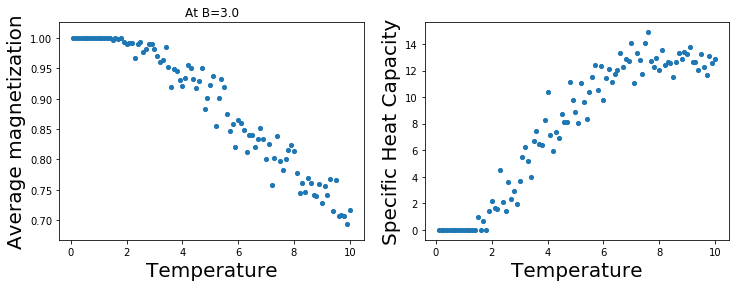

In [25]:
fields(3.0)

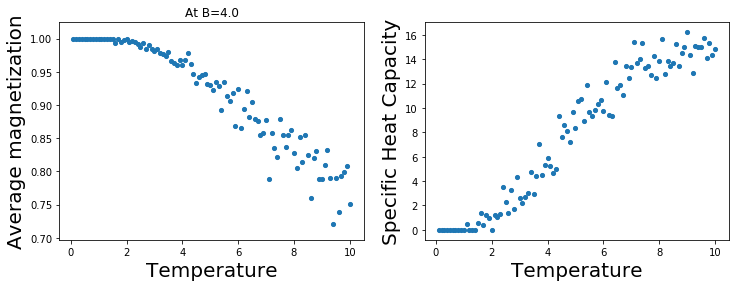

In [26]:
fields(4.0)

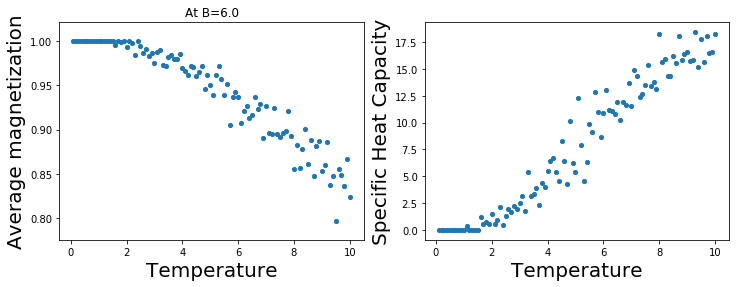

In [27]:
fields(6.0)

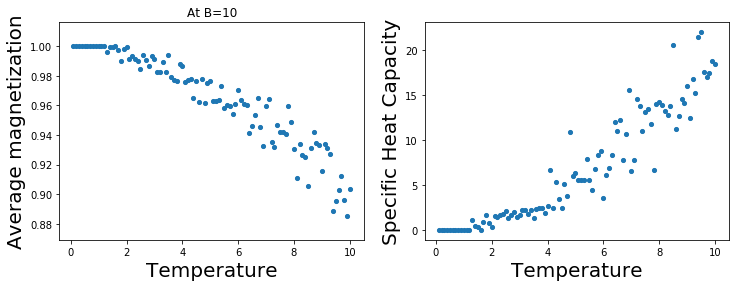

In [28]:
fields(10)

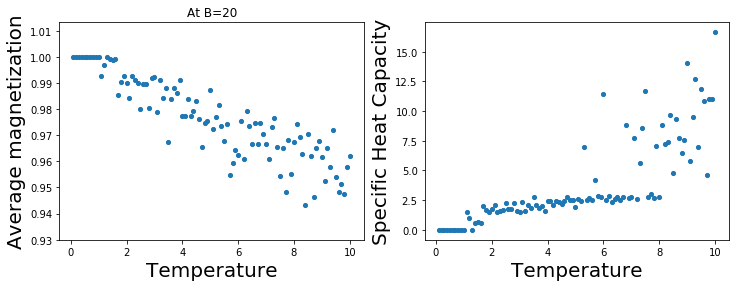

In [29]:
fields(20)

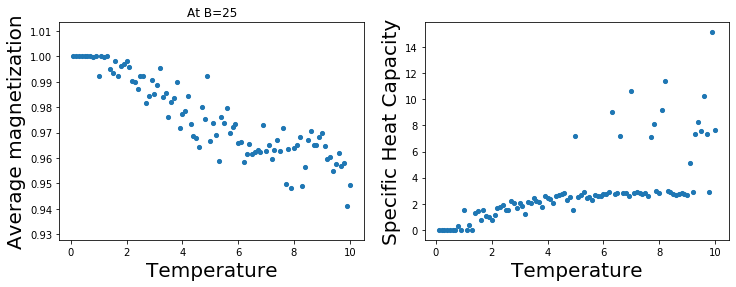

In [30]:
fields(25)

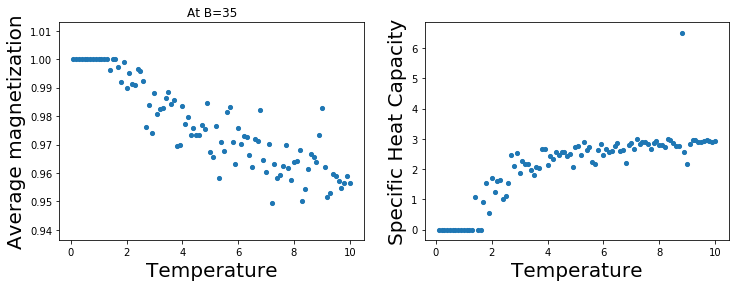

In [31]:
fields(35)

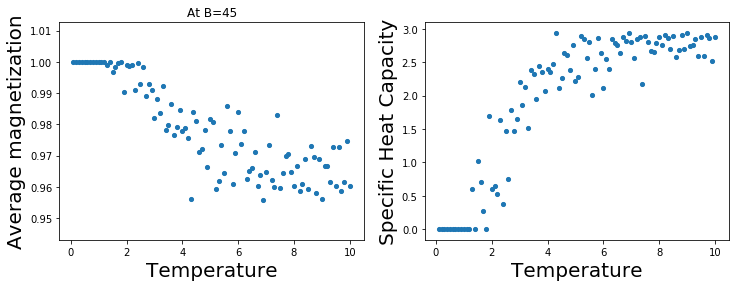

In [32]:
fields(45)